<a href="https://colab.research.google.com/github/LB1593/codici-/blob/master/COVID_CLASSIFIER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-image
!pip install split-folders
!pip install pydicom
!pip install tqdm
!pip install split-folders tqdm
!pip install opencv-python
!pip install feature_selector

In [ ]:
!pip install mahotas==1.4.7

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Implementazione di un algoritmo di machine learning (SVM) per la classificazione di immagini MRI di tumori (maligni e benogni) alle 
# ghiandole salivari .
# -1: generazione di un dataset di training e di test casuale dal database principale , nel seguente modo: 30% pazienti per il test e 70% per il train.
# -2: costruzione dell'algoritmo per la classificazione

import pydicom as dicom
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import random
import mahotas as mt
from sklearn.svm import LinearSVC
import tqdm as tqdm
import splitfolders 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from feature_selector import FeatureSelector
from pandas.plotting import scatter_matrix
from matplotlib.colors import ListedColormap
import pickle
from sklearn.metrics import accuracy_score
import cv2
from numpy import asarray


In [ ]:
# cancello l'output per iniziare nuovamente la scelta randomica
!rm -rf output

In [ ]:

# Creo i dataset di train e test
#datadir='drive/My Drive/img ghiand saliv'
datadir='drive/My Drive/COVID'
splitfolders.ratio(datadir, output="Dataset", seed=1339, ratio=(.7, .0, .3))


Copying files: 929 files [03:53,  3.98 files/s]


In [ ]:
# carico tutte le funzioni utili

#  function to extract haralick textures from a training and test database
def extract_features(image):
	# calculate haralick texture features for 4 types of adjacency
	textures = mt.features.haralick(image)

	# take the mean of it and return it
	ht_mean  = textures.mean(axis=0)
	return ht_mean

# funzione per plottare la funzione decisionale

def plot_decision_function(est):

    xx, yy = np.meshgrid(np.linspace(-3, 3, 500),
                         np.linspace(-3, 3, 500))
    # We evaluate the decision function on the grid.
    Z = est.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cmap = plt.cm.Blues
    # We display the decision function on the grid.
    plt.figure(figsize=(8,8));
    plt.imshow(Z,
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                aspect='auto', origin='lower', cmap=cmap);
    # We display the boundary where Z = 0
    plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                colors='y');
    # All point colors c fall in the interval .5<=c<=1.0 on the blue colormap. We color the true points darker blue.
    plt.scatter(X[:, 0], X[:, 1], s=30, c=.5+.5*y, lw=1, cmap='brg', vmin=0, vmax=1);
    plt.axhline(0, color='k');
    plt.axvline(0, color='k');
    plt.xticks(());
    plt.yticks(());   
    plt.axis([-3, 3, -3, 3]);


In [ ]:
# prelevo le immagini di training
train_path='Dataset/train'
train_names=os.listdir(train_path)

train_names

['covid', 'no_covid']

In [ ]:
# inizializzo le features e le etichette(maligni e benigni) per il training
train_features = []
train_labels = []

# estraggo le features dalle immagini di training

print ("[STATUS] Inizio ad estrarre le features di Haralick..")
for train_name in train_names:
        cur_path = train_path + "/" + train_name
        cur_label = train_name
        i = 1
        for file in glob.glob(cur_path + "/*.*"):
                print ("Elaboro l'immagine - {} in {}".format(i, cur_label))
            
                # leego i file DICOM
                MRI =cv2.imread(file)

                database =asarray(MRI)

                #estraggo fisicamente le features 
                features = extract_features(database)

                # creo un vettore con le features estratte(13) delle immagini dele rispettive etichette(maligni e benigni) 
                train_features.append(features)
                train_labels.append(cur_label)

                # show loop update
                i += 1

[STATUS] Inizio ad estrarre le features di Haralick..
Elaboro l'immagine - 1 in covid
Elaboro l'immagine - 2 in covid
Elaboro l'immagine - 3 in covid
Elaboro l'immagine - 4 in covid
Elaboro l'immagine - 5 in covid
Elaboro l'immagine - 6 in covid
Elaboro l'immagine - 7 in covid
Elaboro l'immagine - 8 in covid
Elaboro l'immagine - 9 in covid
Elaboro l'immagine - 10 in covid
Elaboro l'immagine - 11 in covid
Elaboro l'immagine - 12 in covid
Elaboro l'immagine - 13 in covid
Elaboro l'immagine - 14 in covid
Elaboro l'immagine - 15 in covid
Elaboro l'immagine - 16 in covid
Elaboro l'immagine - 17 in covid
Elaboro l'immagine - 18 in covid
Elaboro l'immagine - 19 in covid
Elaboro l'immagine - 20 in covid
Elaboro l'immagine - 21 in covid
Elaboro l'immagine - 22 in covid
Elaboro l'immagine - 23 in covid
Elaboro l'immagine - 24 in covid
Elaboro l'immagine - 25 in covid
Elaboro l'immagine - 26 in covid
Elaboro l'immagine - 27 in covid
Elaboro l'immagine - 28 in covid
Elaboro l'immagine - 29 in covi

In [ ]:
# stampo le dimensioni il vettore contenente le features di training, e il numero di etichette di training
print ("Training features: {}".format(np.array(train_features).shape))
print ("Training labels: {}".format(np.array(train_labels).shape))



Training features: (650, 13)
Training labels: (650,)


In [ ]:
# creo una tabella [labels x  fetaures] in cui per ogni immagine eleborata rilevo il valore della feature di haralick misurata
#(devo crearla per utilizzare il featureSelector)
#- ASM
#- contr
#-correlation
#- variance
#- IDM
#- Sum Average
#- Sum Variance
#- Sum Entropy
#- Entropy
#- diff variance
#- diff entropy
#- IMC 1
#- IMC 2

# Standardize the feature matrix
new_train_features = StandardScaler().fit_transform(train_features) # normalizzo le train_features


hara_feat=['Ang Sec Mom','Contrast','Corr',' Var','Inv Diff Mom','Sum Avg','Sum Var','Sum Entropy','Entropy','Diff Var','Diff Entropy','Inf Measure of Corr 1','Inf Measure of Corr 2']
train=pd.DataFrame(new_train_features,index=train_labels,columns=hara_feat)






In [ ]:
#train.to_excel('C:\Users\Luca\haralick_feat_from_training_set.xls') 
# grazie alla classe featureSelector possso calcolare automaticamente il numero di feature altamente correlate(rispetto ad una soglia(th))
fs = FeatureSelector( train,train_labels)


b=fs.identify_collinear(correlation_threshold=0.50)

8 features with a correlation magnitude greater than 0.50.



In [ ]:
fs.identify_collinear(correlation_threshold=0.90)
correlated_features = fs.ops['collinear']
print(correlated_features)

4 features with a correlation magnitude greater than 0.90.

['Corr', 'Sum Var', 'Diff Var', 'Inf Measure of Corr 2']


In [ ]:
# grafico la scatter plot delle feature per osservare quale funzione decisionale sia migliore dopo la PCA
train=pd.DataFrame(new_train_features,index=train_labels,columns=hara_feat)
train=train.reset_index()

#sns.pairplot(train,hue="index")

In [ ]:

# compio una PCA sulle 13 features 

# Create a PCA con il numero di feature scelto in base all'alta correlazione(featureSelector).La PCA è un
# ottimo metodo per selezionare le features altamente correlate
pca = PCA(n_components=9, whiten=True)


# Conduct PCA
train_features_pca = pca.fit_transform(new_train_features)


# Show results
print("numero originale di features:", new_train_features.shape[1])
print("numero ridotto di features:", train_features_pca.shape[1])



numero originale di features: 13
numero ridotto di features: 9


In [ ]:
# estraggo features e etichetto anche per le immagini di Test
test_features = []
test_labels = []

test_path = "Dataset/test"
test_names=os.listdir(test_path)




for test_name in test_names:
        cur_path = test_path + "/" + test_name
        cur_label = test_name
        i = 1
        for file in glob.glob(cur_path + "/*.*"):

          print ("Elaboro l'immagine - {} in {}".format(i, cur_label))

       
        # leggo il file Dicom
          MRI =cv2.imread(file)

          dataset =asarray(MRI)


        # estraggo effett. le features di test
          features = extract_features(dataset)
          
         # creo un vettore con le features estratte(13) delle immagini dele rispettive etichette(maligni e benigni) 
          test_features.append(features)
          test_labels.append(cur_label)
         
          #show loop update
          i += 1

          
        # faccio la previsione
           #test_labels_predicted = svclassifier.predict(test_features)
         
        

Elaboro l'immagine - 1 in covid
Elaboro l'immagine - 2 in covid
Elaboro l'immagine - 3 in covid
Elaboro l'immagine - 4 in covid
Elaboro l'immagine - 5 in covid
Elaboro l'immagine - 6 in covid
Elaboro l'immagine - 7 in covid
Elaboro l'immagine - 8 in covid
Elaboro l'immagine - 9 in covid
Elaboro l'immagine - 10 in covid
Elaboro l'immagine - 11 in covid
Elaboro l'immagine - 12 in covid
Elaboro l'immagine - 13 in covid
Elaboro l'immagine - 14 in covid
Elaboro l'immagine - 15 in covid
Elaboro l'immagine - 16 in covid
Elaboro l'immagine - 17 in covid
Elaboro l'immagine - 18 in covid
Elaboro l'immagine - 19 in covid
Elaboro l'immagine - 20 in covid
Elaboro l'immagine - 21 in covid
Elaboro l'immagine - 22 in covid
Elaboro l'immagine - 23 in covid
Elaboro l'immagine - 24 in covid
Elaboro l'immagine - 25 in covid
Elaboro l'immagine - 26 in covid
Elaboro l'immagine - 27 in covid
Elaboro l'immagine - 28 in covid
Elaboro l'immagine - 29 in covid
Elaboro l'immagine - 30 in covid
Elaboro l'immagine 

In [ ]:
# stampo le dimensioni il vettore contenente le features di training, e il numero di etichette di training
print ("Test features: {}".format(np.array(test_features).shape))
print ("Test labels: {}".format(np.array(test_labels).shape))

Test features: (279, 13)
Test labels: (279,)


In [ ]:
## Standardize the feature matrix
new_test_features = StandardScaler().fit_transform(test_features)

# Create a PCA that will retain 99% of variance
pca = PCA(n_components=9, whiten=True)

 # Faccio la PCA
test_features_pca = pca.fit_transform(new_test_features)

print("numero originale di features:", new_test_features.shape[1])
print("numero ridotto di features:", test_features_pca.shape[1])


numero originale di features: 13
numero ridotto di features: 9


In [ ]:
# creo il classificatore 
print ("[STATUS] Creo il classificatore..")
svclassifier = SVC(kernel="rbf", gamma=0.3,C=10000,decision_function_shape ='ovr')
#svclassifier = SVC(kernel="linear",gamma=5,degree=9)

# modello il classificatore sulle features ed etichette di training
print( "[STATUS] Adatto features/label al modello creato..")
#svclassifier.fit(train_features, train_labels)
svclassifier.fit(train_features_pca, train_labels)


# visualizzo la regione di decisione cosi da poter vedere l'accuratezza della classificazione e rivedere i parametri delclassificatore

# creo il dataset di test
test=pd.DataFrame(new_test_features,index=test_labels,columns=hara_feat)

# creo un secondo dataset per creare un array delle etichette(0 e 1) da sfruttare nel graficare la regione di decisione

test_2=test.reset_index()
sost = {'covid': 0, 'no_covid': 1}
test_2['index'] = test_2['index'].map(sost).fillna(test_2['index'])

# plotto la regione
X=np.array(test_features_pca)
y=np.asarray(test_2['index'])
#plot_decision_function(svclassifier)


# visualizzo la regione di decisione cosi da poter vedere l'accuratezza della classificazione e rivedere i parametri delclassificatore

# creo il dataset di test
test=pd.DataFrame(new_test_features,index=test_labels,columns=hara_feat)

# creo un secondo dataset per creare un array delle etichette(0 e 1) da sfruttare nel graficare la regione di decisione

test_2=test.reset_index()
sost = {'covid': 0, 'no_covid': 1}
test_2['index'] = test_2['index'].map(sost).fillna(test_2['index'])

# plotto la regione
X=np.array(test_features_pca)
y=np.asarray(test_2['index'])
#plot_decision_function(svclassifier)

# faccio la previsione
#test_labels_predicted = svclassifier.predict(test_features)
test_labels_predicted = svclassifier.predict(test_features_pca)






[STATUS] Creo il classificatore..
[STATUS] Adatto features/label al modello creato..


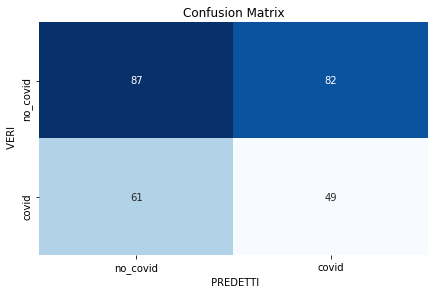

             precision    recall  f1-score   support

      covid       0.59      0.51      0.55       169
   no_covid       0.37      0.45      0.41       110

avg / total       0.50      0.49      0.49       279



In [ ]:
cm=np.array(confusion_matrix(test_labels,test_labels_predicted))
confusion=pd.DataFrame(cm,index=['no_covid','covid'], columns=['no_covid','covid'])
sns.heatmap(confusion, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel(" VERI"), plt.xlabel(" PREDETTI")
plt.show()
print(classification_report(test_labels,test_labels_predicted))


In [ ]:
!pip install nilearn

     |████████████████████████████████| 2.5MB 2.7MB/s 


In [ ]:
import nibabel as nib
 
img1 = nib.load('C:/Users/Bestengage/Desktop/COVID-19-CT-Seg_20cases/coronacases_org_001.nii')
data = img1.get_data()
affine = img1.affine
 
print(img1)
 


FileNotFoundError: ignored